Competition goal: Produce an algorithm that predicts which Place entries represent the same point-of-interest.


Files
*   Train data -> over 1 million entries of location with the attributes of location and the identifier of POI it represents  
*   Pairs data -> pregenerated set of pairs of place entries from train data to improve detection matches
*   Test data -> sample test data set to identify the POI 








# Data Loading and Pre-processing

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## reading files 
df_train = pd.read_csv('/content/drive/MyDrive/CPSC4830/Finals/train.csv') 
df_test = pd.read_csv('/content/drive/MyDrive/CPSC4830/Finals/test.csv')
df_pairs = pd.read_csv('/content/drive/MyDrive/CPSC4830/Finals/pairs.csv')

### train csv data initial checking 

Data has 1.14 million records and 13 columns. Most of the columns are object data type, except for latitude and longitude. 

Column definition based on initial observation of the data below.
- ID is the unique identifier of each observation as the unique values is same as the total number of obs
- Name is the location name
- Latitude / longitude is the geographic coordinates of the place 
- Address, city, state, zip, country are location identifier
- Url and phone are location contact 
- Categories type of location (i.e. restaurant, salon)
- Point of interest label to identify which POI the entry is

In [ ]:
##checking what train data looks like
print('Shape of the data number of obs x col', df_train.shape)
df_train.info()

Shape of the data number of obs x col (1138812, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [ ]:
##sample train data
df_train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [ ]:
df_train.loc[df_train.point_of_interest=='P_809a884d4407fb', df_train.columns != 'point_of_interest']

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants
560864,E_7e0d8e9138dd56,Casa Cofiño,43.338130,-4.326717,Barrio de los Caviedes s/n,Valdáliga / Cantabria,Spain,39593,ES,NaN,34942708046,Spanish Restaurants


In [ ]:
## unique values in each columns
## there are more than 739k unique POIs 
df_train.nunique()

id                   1138812
name                  842086
latitude             1121701
longitude            1080273
address               558154
city                   68105
state                  17596
zip                    93329
country                  221
url                   171222
phone                 293454
categories             52578
point_of_interest     739972
dtype: int64

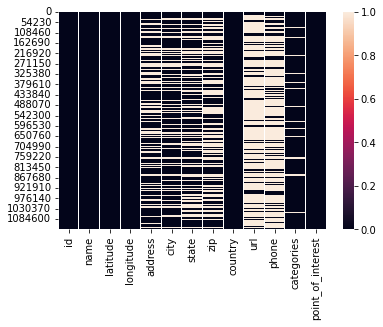

In [ ]:
##null values checking
##most null on address, city, state, zip, url, phone
sns.heatmap(df_train.isnull())

### test data initial checking

Based on initial data checking below, it seems the data will only be used as final validation for the final model as there are only 5 records. Test data set for the actual modelling process would still come from by splitting the available train data. 

Columns are the same with train data except for the POI column. Zip and phone seems to be in numerical format compared to the train data. 

In [ ]:
##check shape of the data
print('Number of obs x cols:', df_test.shape)
df_test.info()

Number of obs x cols: (5, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5 non-null      object 
 1   name        5 non-null      object 
 2   latitude    5 non-null      float64
 3   longitude   5 non-null      float64
 4   address     3 non-null      object 
 5   city        3 non-null      object 
 6   state       2 non-null      object 
 7   zip         2 non-null      float64
 8   country     5 non-null      object 
 9   url         1 non-null      object 
 10  phone       1 non-null      float64
 11  categories  5 non-null      object 
dtypes: float64(4), object(8)
memory usage: 608.0+ bytes


In [ ]:
df_test.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434209,-80.564160,497 N 12th St,Weirton,WV,26062.0,US,NaN,NaN,Bars
2,E_00002f98667edf,QIWI,47.215134,39.686088,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,7.800301e+10,ATMs
3,E_001b6bad66eb98,"Gelora Sriwijaya, Jaka Baring Sport City",-3.014675,104.794374,NaN,NaN,NaN,NaN,ID,NaN,NaN,Stadiums
4,E_0283d9f61e569d,Stadion Gelora Sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,Soccer Stadiums


### Pairs data initial checking

Data have 25 columns. Columns seem to the same as train data but there's two sets of it to identify the attributes of the two locations being compared. 

Match column is a boolean identifier that categorizes if the two entries matches. 

In [ ]:
##check shape of the data
print('Number of obs x cols:', df_pairs.shape)
df_pairs.info()

Number of obs x cols: (578907, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          578907 non-null  object 
 1   name_1        578907 non-null  object 
 2   latitude_1    578907 non-null  float64
 3   longitude_1   578907 non-null  float64
 4   address_1     475383 non-null  object 
 5   city_1        512928 non-null  object 
 6   state_1       452316 non-null  object 
 7   zip_1         359509 non-null  object 
 8   country_1     578899 non-null  object 
 9   url_1         231806 non-null  object 
 10  phone_1       270022 non-null  object 
 11  categories_1  562613 non-null  object 
 12  id_2          578907 non-null  object 
 13  name_2        578907 non-null  object 
 14  latitude_2    578907 non-null  float64
 15  longitude_2   578907 non-null  float64
 16  address_2     312497 non-null  object 
 17  city_2       

In [ ]:
##snippet of data
df_pairs[["name_1", "state_1", "country_1", "name_2", "state_2", "country_2"]]

,name_1,state_1,country_1,name_2,state_2,country_2
0,Café Stad Oudenaarde,Oost-Vlaanderen,BE,Café Oudenaarde,NaN,BE
1,Turkcell,NaN,TR,Turkcell,NaN,TR
2,Island Spa,Metro Manila,PH,Island Spa Theater,NaN,PH
3,TOGO'S Sandwiches,CA,US,Togo's,CA,US
4,Coffee Cat,Davao Region,PH,Coffeecat,Davao Region,PH
...,...,...,...,...,...,...
578902,Blk 332 Hougang Avenue 5,Singapore,SG,Blk332 Carpark,NaN,SG
578903,Fawsley Hall,Northants,GB,The Spa At Fawsley Hall,NaN,GB
578904,Cricket Wireless Authorized Retailer,TN,US,Cricket Wireless Authorized Retailer,TN,US
578905,焼肉 和家,東京都,JP,Nagomiya,NaN,JP


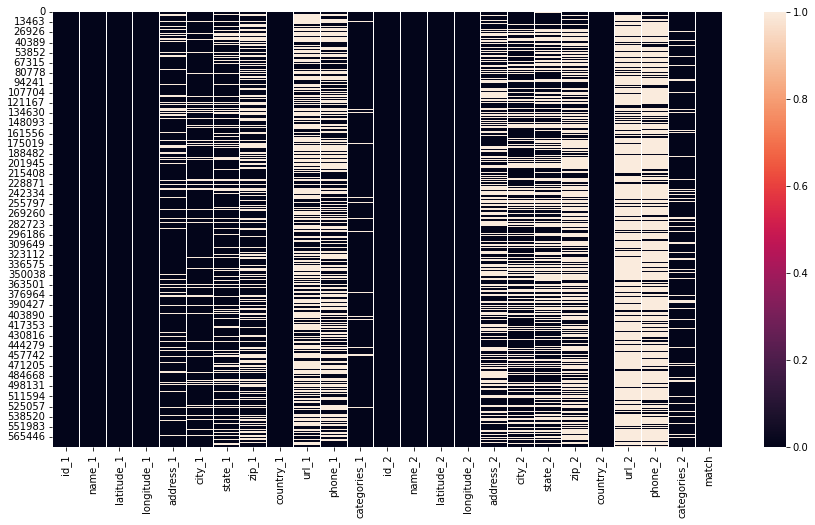

In [ ]:
##most nulls in url and phone, most probably this attribute would not be used as a way to match 
##latitude, longitude, and country has no null --> it seems this is used as big identifier for matching 
plt.figure(figsize=(15,8))
sns.heatmap(df_pairs.isna())

### Some visualization

Data classification distribution: 68.9% match records, 31.1% not match records
Imbalance on the data is not too much of concern. 150k records of not match records would still be sufficient for classification. Therefore, no over/under sampling to be applied

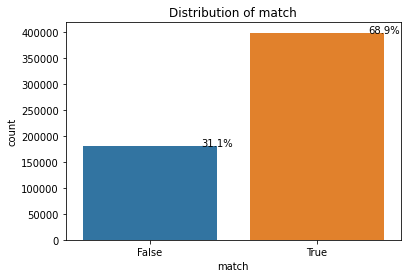

In [ ]:

ax = sns.countplot(x="match", data=df_pairs)
total = float(len(df_pairs))

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    plt.title('Distribution of match')
    ax.annotate(percentage, (x, y),ha='center')    
plt.show()

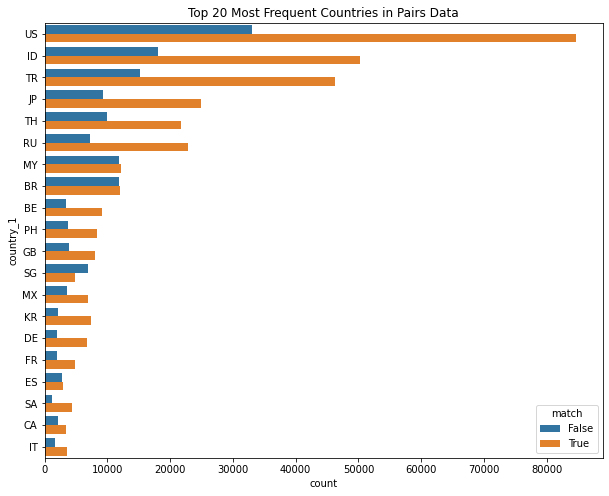

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Top 20 Most Frequent Countries in Pairs Data')

sns.countplot(y='country_1', hue='match',  data=df_pairs, order=df_pairs['country_1'].value_counts().iloc[0:20].index)

US has the most place entries, followed Turkey, India, Japan, and Thailand. Most of the US locations latitude ranges 25-50 and longitude -170 to -80.

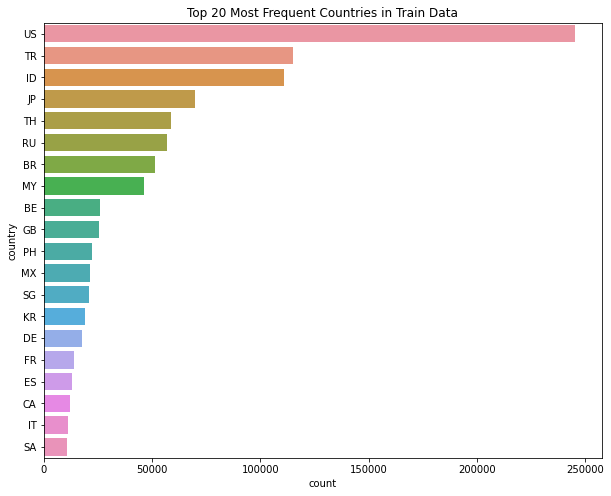

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Top 20 Most Frequent Countries in Train Data')
sns.countplot(y=df_train['country'], order=df_train['country'].value_counts().iloc[0:20].index)

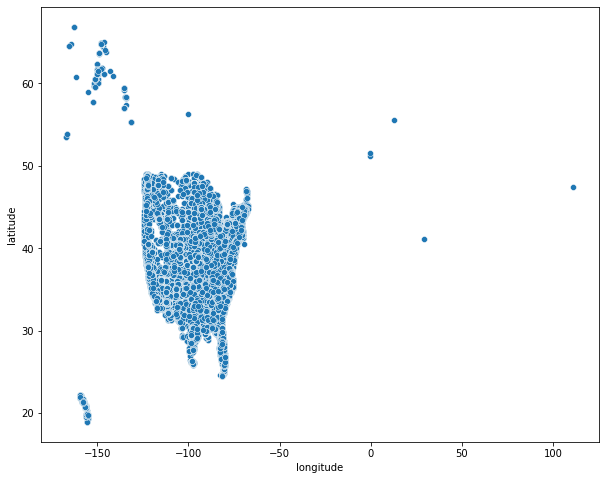

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(y='latitude', x='longitude', data=df_train[df_train.country=='US'])

### data exploration of matching entries

In the match records, we observed that: 

*   latitude and longitude are close 
*   countries are same
*   categories are identical
*   location name seems to be same but some are shorter version

In [ ]:
##checking some match locations

display(df_pairs.loc[df_pairs.match==True, ['id_1' ,'name_1' ,'latitude_1' ,'longitude_1' ,'address_1' ,'city_1' ,'state_1' ,'zip_1' ,'country_1' ,'url_1' ,'phone_1' ,'categories_1' ]].head(10))

display(df_pairs.loc[df_pairs.match==True, ['id_2' ,'name_2' ,'latitude_2' ,'longitude_2' ,'address_2' ,'city_2' ,'state_2' ,'zip_2' ,'country_2' ,'url_2' ,'phone_2' ,'categories_2' ]].head(10))

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,NaN,Spas
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,7074394747,Sandwich Places
5,E_0000c566a81ea1,つじ田 味噌の章,35.694796,139.767348,神田小川町1-1,千代田区,東京都,101-0052,JP,https://tsukemen-tsujita.com,366597676,Ramen Restaurants
6,E_0000d9e584ed9f,Signature Properties Savannah,32.012582,-81.113156,100 Commercial Ct Ste C,Savannah,GA,31406,US,http://www.oursignatureproperties.com,9126292700,Real Estate Offices
7,E_00011cca3f0bd6,Inner Workings,35.686930,-105.939167,Serving General Area,Santa Fe,NM,87501,US,http://innerworkingsmassage.com,(505) 850-0872,Massage Studios
9,E_0001827d6b4ee2,Marshall Boya Bayi,38.534796,30.548005,İplik Mah. Zafer Sok. 4 Şuhut,Afyonkarahisar,NaN,NaN,TR,http://www.marshallboya.com,2727181525,Hardware Stores
11,E_0001a397f67ad5,Dale City Truck-Only Safety Rest Area North,38.599821,-77.312595,Interstate 95 North,Montclair,VA,22026,US,http://www.virginiadot.org/travel/map-ra-dalec...,8003677623,Rest Areas
12,E_00024204e83804,Lukoil,51.172940,4.125157,Vlyminckshoek,Sint-Niklaas,Vlaams Gewest,9100,BE,NaN,NaN,Gas Stations
13,E_000288f2046ce3,Lidl,51.060776,13.681555,Cossebauder Str. 6,Dresden-Cotta,Sachsen,01157,DE,https://www.lidl.de,8004353361,"Supermarkets, Discount Stores"


,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2
0,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars
2,E_12453effe251db,Island Spa Theater,14.518330,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas
3,E_f131dcb7f07be9,Togo's,38.257938,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places
5,E_8d58f3151bae83,味噌の章,35.694598,139.767981,NaN,NaN,NaN,NaN,JP,NaN,NaN,Noodle Houses
6,E_caad79f6ed7c44,Signature Properties Savannah,32.010621,-81.108089,7014 Abercorn St,Savannah,GA,31406,US,NaN,NaN,NaN
7,E_aeffddf31a4b9e,Inner Workings,35.685919,-105.939617,Serving General Area,Santa Fe,NM,87501,US,NaN,+15058500872,Massage Studios
9,E_902096602680c1,Marshall Boya Bayi,38.534438,30.549282,İpek Mah. Gençlik Cad. 24 Şuhut,Afyonkarahisar,NaN,NaN,TR,http://www.marshallboya.com,2727183512,Hardware Stores
11,E_4b83e498f06eff,I-95 Exit 152 Truck Stop,38.593718,-77.316549,NaN,Dumfries,VA,22026,US,NaN,NaN,Rest Areas
12,E_df4dfa1a4794de,lukoil sint - niklaas kleibeke,51.173249,4.124810,NaN,NaN,NaN,NaN,BE,NaN,NaN,Gas Stations
13,E_23f8fce694c9a5,Lidl,51.064710,13.674510,Meißner Str. 41,Radebeul-Ost,NaN,1445,DE,http://www.lidl.de,8004353361,Grocery Stores


In [ ]:
##checking the match records from train data
display(df_train[df_train.id=='E_000001272c6c5d'],df_train[df_train.id=='E_da7fa3963561f8'])
display(df_train[df_train.id=='E_0000d9e584ed9f'],df_train[df_train.id=='E_caad79f6ed7c44'])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
972683,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,P_677e840bb6fc7e


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
13,E_0000d9e584ed9f,Signature Properties Savannah,32.012582,-81.113156,100 Commercial Ct Ste C,Savannah,GA,31406,US,http://www.oursignatureproperties.com,9126292700,Real Estate Offices,P_af856e3abdcebc


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
902359,E_caad79f6ed7c44,Signature Properties Savannah,32.010621,-81.108089,7014 Abercorn St,Savannah,GA,31406,US,NaN,NaN,NaN,P_af856e3abdcebc


In [ ]:
##is there any match records but doesn't have the same point of interest?? 
samp = df_pairs[df_pairs.match==True] 
samp = samp.merge(df_train[['point_of_interest','id']], how="left", left_on="id_1", right_on='id').rename(columns={'point_of_interest':'poi_1'})
samp = samp.merge(df_train[['point_of_interest','id']], how="left", left_on="id_2", right_on='id').rename(columns={'point_of_interest':'poi_2'})
samp[samp.poi_1 != samp.poi_2]

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,zip_2,country_2,url_2,phone_2,categories_2,match,poi_1,id_x,poi_2,id_y


In [ ]:
##checking sample unmatch records
display(df_pairs.loc[df_pairs.match==False, ['id_1' ,'name_1' ,'latitude_1' ,'longitude_1' ,'address_1' ,'city_1' ,'state_1' ,'zip_1' ,'country_1' ,'url_1' ,'phone_1' ,'categories_1' ]].head(5))
display(df_pairs.loc[df_pairs.match==False, ['id_2' ,'name_2' ,'latitude_2' ,'longitude_2' ,'address_2' ,'city_2' ,'state_2' ,'zip_2' ,'country_2' ,'url_2' ,'phone_2' ,'categories_2' ]].head(5))

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops"
8,E_00015cd7e0227f,Lake Destiny,28.643613,-81.389132,NaN,Maitland,FL,32751,US,NaN,NaN,Lakes
10,E_000184ea12d0f0,ざま駅前歯科医院,35.480396,139.400101,入谷東3-60-2,座間市,神奈川県,252-0028,JP,https://www.z-shika.com,+81462666868,Dentist's Offices
14,E_0002b0ae551c83,イオン乙金ショッピングセンター,33.543487,130.496612,乙金3-23-1 / 乙金3-24-1,大野城市,福岡県,816-0902,JP,http://otogana.aeonkyushu.com,+81925130150,Shopping Malls


,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2
1,E_3f12df0b045062,Turkcell,37.838020,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores
4,E_d52c3c4d53831c,Coffeecat,7.076016,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops"
8,E_7250ab441d9d42,Lake destiny field,28.629306,-81.391977,NaN,Maitland,FL,32751,US,NaN,NaN,Soccer Fields
10,E_f7c62a89c518a5,座間駅前交番,35.480241,139.400504,入谷東3-60-3,座間市,神奈川県,252-0028,JP,https://www.police.pref.kanagawa.jp,NaN,Police Stations
14,E_cd42d897067627,イオン乙金SC北街区,33.545437,130.496660,乙金3-23-1,大野城市,福岡県,816-0902,JP,NaN,NaN,Shopping Malls


In [ ]:
##checking how the pair of unmatch records from train data
display(df_train[df_train.id=='E_000008a8ba4f48'],df_train[df_train.id=='E_3f12df0b045062'])
display(df_train[df_train.id=='E_0000c362229d93'],df_train[df_train.id=='E_d52c3c4d53831c'])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
3,E_000008a8ba4f48,Turkcell,37.84451,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
281004,E_3f12df0b045062,Turkcell,37.83802,27.84556,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,P_d0ec3812aeae00


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
11,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",P_c9997611c608a1


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
949031,E_d52c3c4d53831c,Coffeecat,7.076016,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",P_477e5c8ed22a34


In [ ]:
##is there not match records but identified as same POI??
samp = df_pairs[df_pairs.match==False] 
samp = samp.merge(df_train[['point_of_interest','id']], how="left", left_on="id_1", right_on='id').rename(columns={'point_of_interest':'poi_1'})
samp = samp.merge(df_train[['point_of_interest','id']], how="left", left_on="id_2", right_on='id').rename(columns={'point_of_interest':'poi_2'})
samp[samp.poi_1 == samp.poi_2]

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,zip_2,country_2,url_2,phone_2,categories_2,match,poi_1,id_x,poi_2,id_y


### data cleaning

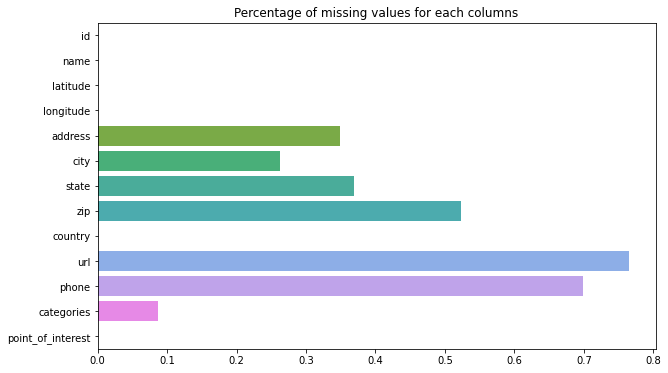

In [ ]:
##plotting amount of missing values
##url and phone data is more than 50% missing 
##consider name, lat, long, country, categories column as predictor for now?? 
plt.figure(figsize=(10,6))
plt.title('Percentage of missing values for each columns')
sns.barplot(y=df_train.columns , x= df_train.isna().sum() /len(df_train))
plt.show()

Text(0.5, 1.0, 'longitude')

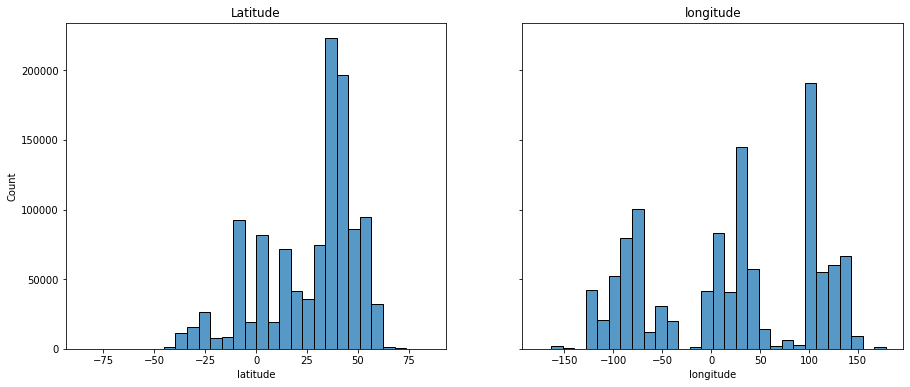

In [ ]:
##latitude and longitude in degrees
##haversine function needs degrees [-90,90] (lat) and [-180,180] (lon)
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data=df_train, x='latitude', bins=30, ax=ax[0])
sns.histplot(data=df_train, x='longitude', bins=30, ax=ax[1])
ax[0].set_title('Latitude')
ax[1].set_title('longitude')

In [ ]:
##splitting data
from sklearn.model_selection import train_test_split

##select the columns with few missing values for now
sel_col = ['id_1' ,'name_1' ,'latitude_1' ,'longitude_1' ,'address_1', 'country_1' ,'categories_1' ,
              'id_2' ,'name_2' ,'latitude_2' ,'longitude_2' ,'address_2','country_2' ,'categories_2' ]
label = 'match'

#X_train,X_test,y_train, y_test = train_test_split(df_pairs['name_1'].apply(lambda x: x.lower()), df_pairs['match'], test_size=0.2, random_state=30)
X_train,X_test,y_train, y_test = train_test_split(df_pairs[sel_col], df_pairs[label], test_size=0.2, random_state=30)
print("Train: ",X_train.shape,y_train.shape,"\nTest: ",(X_test.shape,y_test.shape))

Train:  (463125, 14) (463125,) 
Test:  ((115782, 14), (115782,))


In [ ]:
##install haversine formula calculation for lat and long
!pip install haversine 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install haversine 
from haversine import haversine, Unit

X_train['lat_long_1'] = list(zip(X_train.latitude_1, X_train.longitude_1))
X_train['lat_long_2'] = list(zip(X_train.latitude_2, X_train.longitude_2))

X_train['dist_loc'] = X_train.apply(lambda x: haversine(x['lat_long_1'], x['lat_long_2']), axis=1)
X_train.head(5)
#haversine(df_pairs.lat_long_1[0], df_pairs.lat_long_2[0], unit='km')

,id_1,name_1,latitude_1,longitude_1,address_1,country_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,country_2,categories_2,lat_long_1,lat_long_2,dist_loc
370216,E_a394142d0145d8,JR高速バスのりば,35.679565,139.768191,丸の内1-9-1,JP,Bus Stations,E_f35801d6eeddde,東京駅 八重洲南口 高速バス乗り場,35.679388,139.768285,丸の内1-9-1,JP,Bus Stations,"(35.67956541308432, 139.7681905977463)","(35.67938755211566, 139.76828544497195)",0.021553
84884,E_258528964aad3c,メディアカフェポパイ RR町田店,35.542485,139.449001,原町田4-11-14,JP,"Internet Cafes, Cafés",E_d6a190581e2233,MediaCafe POPEYE メディアカフェ ポパイ 町田店,35.542508,139.448708,NaN,JP,Internet Cafes,"(35.542485147970275, 139.4490009632754)","(35.542507896432674, 139.44870803198066)",0.026624
552396,E_f4128a9d2c2dd4,Hotel Santika Premiere Slipi Jakarta,-6.198239,106.802309,Jalan Aipda Karel Satsuit Tubun No. 7,ID,Hotels,E_69d4c07963b565,Santika Premier Hotel,-6.195287,106.799860,Jl. Satsuit Tubun,ID,Hotels,"(-6.198239217397325, 106.80230856792198)","(-6.195287389174605, 106.79986018321092)",0.425429
240063,E_69d6d1437461e0,Six Flags Great Escape Lodge & Indoor Waterpark,43.351943,-73.697019,89 Six Flags Dr,US,"Theme Parks, Hotels, Water Parks",E_ccf0188c90ea94,Room 128 at The Great Escape Lodge,43.351921,-73.696875,NaN,US,Resorts,"(43.35194265829197, -73.69701862335205)","(43.351921, -73.696875)",0.011860
228703,E_64bcd64e880e3f,Chicharroneria Rodriguez,-12.116556,-77.022816,Gonzales Prada,PE,"BBQ Joints, Sandwich Places",E_738b96033afa7a,Chicharroneria Rodriguez 2,-12.111922,-77.024120,NaN,PE,Peruvian Restaurants,"(-12.116556051473454, -77.02281572612661)","(-12.111922484757669, -77.0241203071133)",0.534395


Text(0.5, 1.0, 'After log transform')

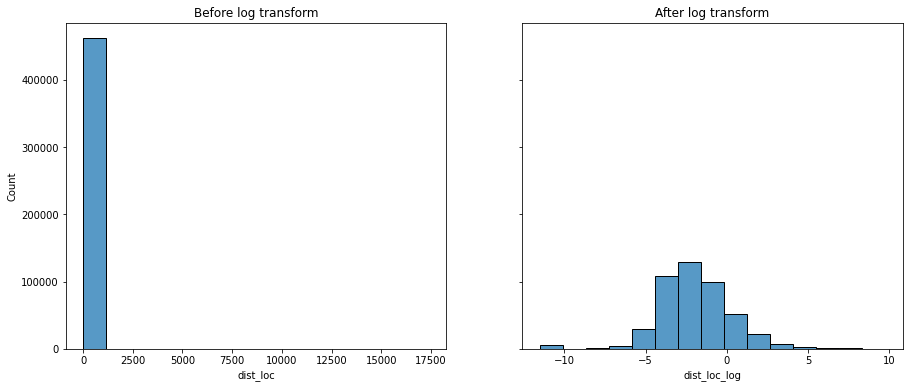

In [ ]:
##haversine distance results is highly skewed thus log transforming dist_loc
X_train['dist_loc_log'] = X_train['dist_loc'].apply(lambda x: np.log(x +0.00001))

fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data=X_train, x='dist_loc', bins=15, ax=ax[0])
sns.histplot(data=X_train, x='dist_loc_log', bins=15, ax=ax[1])
ax[0].set_title('Before log transform')
ax[1].set_title('After log transform')

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149862 sha256=3ca43c558092bb0253b5c5452477d498c11e214690f56238c9d13072040a7de3
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
##string similarity calculation
#!pip install fuzzywuzzy
#!pip install python-Levenshtein

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time

start = time.time()
X_train['fuzz_name'] = X_train.apply(lambda x: fuzz.token_sort_ratio(str(x['name_1']).lower(), str(x['name_2']).lower()) , axis=1)
X_train['fuzz_address'] = X_train.apply(lambda x: fuzz.token_sort_ratio(str(x['address_1']).lower(), str(x['address_2']).lower()) , axis=1)
X_train['fuzz_country'] = X_train.apply(lambda x: fuzz.token_sort_ratio(str(x['country_1']).lower(), str(x['country_2']).lower()) , axis=1)
X_train['fuzz_categories'] = X_train.apply(lambda x: fuzz.token_sort_ratio(str(x['categories_1']).lower(), str(x['categories_2']).lower()) , axis=1)

print("Time taken: %s seconds" % (time.time() - start))

Time taken: 99.8569643497467 seconds


In [ ]:
sel_col = ['dist_loc_log', 'fuzz_name', 'fuzz_address', 'fuzz_country','fuzz_categories']

X_train[sel_col].head(5)

,dist_loc_log,fuzz_name,fuzz_address,fuzz_country,fuzz_categories
370216,-3.836777,38,100,100,100
84884,-3.625560,33,0,100,85
552396,-0.854634,74,62,100,100
240063,-4.433754,56,11,100,22
228703,-0.626601,96,24,100,30


In [ ]:
##nearest neighbor name
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train[sel_col], y_train)

y_train_pred = neigh.predict(X_train[sel_col])
score_train = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {score_train}")

print("Execution Time %s minutes: " % (round((time.time() - start_time)/60 , 2)))

Training accuracy: 0.8380912280701754
Execution Time 0.99 minutes: 


              precision    recall  f1-score   support

       False       0.77      0.69      0.73    144161
        True       0.87      0.90      0.88    318964

    accuracy                           0.84    463125
   macro avg       0.82      0.80      0.81    463125
weighted avg       0.84      0.84      0.84    463125



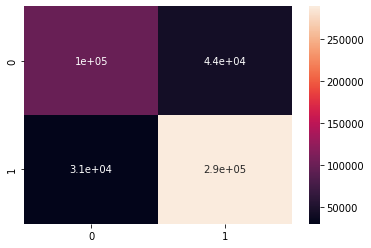

In [ ]:
##training accuracy
cf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf_matrix, annot=True)

print(classification_report(y_train, y_train_pred))

In [ ]:
###test data pre-processing
X_test['lat_long_1'] = list(zip(X_test.latitude_1, X_test.longitude_1))
X_test['lat_long_2'] = list(zip(X_test.latitude_2, X_test.longitude_2))

X_test['dist_loc'] = X_test.apply(lambda x: haversine(x['lat_long_1'], x['lat_long_2']), axis=1)
X_test['dist_loc_log'] = X_test['dist_loc'].apply(lambda x: np.log(x +0.00001))

X_test['fuzz_name'] = X_test.apply(lambda x: fuzz.token_sort_ratio(str(x['name_1']).lower(), str(x['name_2']).lower()) , axis=1)
X_test['fuzz_address'] = X_test.apply(lambda x: fuzz.token_sort_ratio(str(x['address_1']).lower(), str(x['address_2']).lower()) , axis=1)
X_test['fuzz_country'] = X_test.apply(lambda x: fuzz.token_sort_ratio(str(x['country_1']).lower(), str(x['country_2']).lower()) , axis=1)
X_test['fuzz_categories'] = X_test.apply(lambda x: fuzz.token_sort_ratio(str(x['categories_1']).lower(), str(x['categories_2']).lower()) , axis=1)

X_test[sel_col].head(5)

,dist_loc_log,fuzz_name,fuzz_address,fuzz_country,fuzz_categories
558346,-2.954533,38,0,100,67
169225,-11.512925,63,50,100,100
575536,5.228632,48,27,100,11
141167,0.468718,100,18,100,33
152664,-3.425495,81,15,100,100


In [ ]:
##predicting test dataset


### trial tfidf

In [ ]:
import re

def ngrams(string, n=3):
    string = string.lower()
    string = string.title()
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

print('All 3-grams in "McDonalds":')
ngrams('McDonalds')

#X_train['name_1_ngrams'] = X_train['name_1'].apply(lambda x: ngrams(x))

All 3-grams in "McDonalds":


['Mcd', 'cdo', 'don', 'ona', 'nal', 'ald', 'lds']

In [ ]:
##splitting train data trying for US for now 
remove_col = ['url','phone','address','city','state','zip']

df_train_US = df_train.loc[df_train.country=='US',~df_train.columns.isin(remove_col)]
df_train_US = df_train_US.dropna()

sel_col = ['id' ,'name' ,'latitude' ,'longitude' ,'country' ,'categories']
label = 'point_of_interest'

X_train,X_test,y_train, y_test = train_test_split(df_train_US.loc[:,df_train_US.columns.isin(sel_col)], df_train_US.loc[:,df_train_US.columns == label], test_size=0.2, random_state=30)
print("Train: ",X_train.shape,y_train.shape,"\nTest: ",(X_test.shape,y_test.shape))



Train:  (185706, 6) (185706, 1) 
Test:  ((46427, 6), (46427, 1))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

##need to use ngrams because the name of the restaurant will only 1 - 3 unique words
vectorizer= TfidfVectorizer(min_df=1, analyzer=ngrams)

X_train_tf = vectorizer.fit_transform(X_train['name']) ###(X_train['name_1'])for pairs data

X_test_tf = vectorizer.transform(X_test['name']) ###(X_test['name_1'])for pairs data

print(X_train_tf.shape, X_test_tf.shape)

(185706, 32983) (46427, 32983)


In [ ]:
##append into dataframe
import pandas as pd
x_train_app = pd.DataFrame(X_train_tf.toarray(), columns=vectorizer.get_feature_names())
print(x_train_app)

In [ ]:
##nearest neighbor name
from sklearn.neighbors import NearestNeighbors
import time

start_time = time.time()
nbrs = NearestNeighbors(n_neighbors = 5, metric = 'cosine',  n_jobs=-1).fit(X_train_tf)

distances, indices = nbrs.kneighbors(X_train_tf)

print("Execution Time %s minutes: " % (round((time.time() - start_time)/60 , 2)))

Execution Time 34.53 minutes: 


In [ ]:
print(list(enumerate(indices[0:10])))
display(X_train.iloc[0], X_train.iloc[178066])

[(0, array([     0,  73239,  97923, 178066, 127860])), (1, array([     1,  77445,  48785,  20465, 105874])), (2, array([     2, 175714,   6810,  69281, 164003])), (3, array([ 18445,  39649,  55352, 135992, 156431])), (4, array([ 48464,   2753, 140092, 140078, 140151])), (5, array([159883,  57291, 167626, 162717,  15231])), (6, array([ 28287,  43699,  95109, 181904,  28148])), (7, array([     7,   8858,  77173,  60367, 133002])), (8, array([106984,  88419,      8, 169373, 129983])), (9, array([     9, 179941,  89197,   7377, 142160]))]


id            E_9d4aa8c3621700
name          Linn County Jail
latitude             41.974377
longitude           -91.669334
country                     US
categories     Police Stations
Name: 700315, dtype: object

id            E_72f2d32d021029
name          Wake County Jail
latitude             35.775374
longitude           -78.641544
country                     US
categories             Prisons
Name: 511332, dtype: object

In [ ]:
matches = [(round(distances[i][0], 4), X_train.loc[i,:], X_train.loc[j[1]]) 
               for i, j in enumerate(indices[0:10])]
matches

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
import time

#start = time.time()
#cosine_sim = linear_kernel(X_train_tf, X_train_tf)

# Print time taken
#print("Time taken: %s seconds" % (time.time() - start))

### processing


ues: 
Group POI
- whats the maximum distance between two places to be considered in same POI? (same city, address, zip code??)

cleaning:
- remove non english records
- fill names of cities using lat and long
- Vectorize the names of the places 

Algorithm:

1. First match within same countries
2. Second would be to match same city
3. Match with same category (vectorise the cateogry?)
4. If category is not present then match name(?)


In [ ]:
"""
some error stuffs


Error!! ＣＯＺＭＩＸⅡ
Error!! 711
Error!! 366
Error!! 112
Error!! 25 🙌
Error!! 2025
Error!! 020
Error!! 3003
Error!! ﾊﾟﾝｾ
Error!! 645
Error!! 2223
Error!! 62
Error!! 018
Error!! 嘿！！！！！！！！！！！！！！！！！！！！！
Error!! 366
Error!! 
Error!! 409
Error!! Bagh🌳🐝🐞🐜🐛🍀🌱🌿🌷🌾🍃
Error!! 320
Error!! 511  
Error!! 7310
Error!! 359116
Error!! 485623822978754
Error!! 105
Error!! 416
Error!! 38
Error!! 410
Error!! 004
Error!! 0133
Error!! ＮＯＡＨ
Error!! 366
Error!! 7 62
Error!! 170206
Error!! 754579086434
Error!! Salon Eris 💇🏻‍♂️😎✌🏻🤳🏼🔜🇹🇷💇🏻‍♂️😊
Error!! 020110
Error!! ျမိတ္ေမာင္တိတ္ ကတ္ေၾကးကိုက္
Error!! 070336
Error!! ＫＡＺＵ
Error!! 200004
Error!! ６６９
Error!! 126
Error!! 366
Error!! 152💔🚶🏻
Error!! 711
Error!! 711
Error!! 2209
Error!! 724
Error!! 23
Error!! 412
Error!! 113 👭
Error!! M 42 🇹🇭🇬🇧
Error!! 711
Error!! 2202
Error!! 51
Error!! 138
Error!! 
Error!! 45
Error!! 366
Error!! 104
Error!! 1024  66
Error!! 113
Error!! 22
Error!! 1316
Error!! 2024
Error!! 711
Error!! 6501
Error!! 0545
Error!! 504😍😍
Error!! 580
Error!! Carpenter Realtor
Error!! McDonalds
Error!! AL 10A
Error!! Ｓ．ＧＲＡＶＩＴＹ
Error!! 393
Error!! 711
Error!! Bodrum Marina Yatch Club
Error!! Fitpoint Fitness Club
Error!! CONAD CITY



"""

## Logistic Regression

- pair data based on POI
- Calculates text similarity b/w name and categories of a paired data
- calculate distance b/w the two data points
- Perform logistic regression to find whether its a match or not

### Cleaning

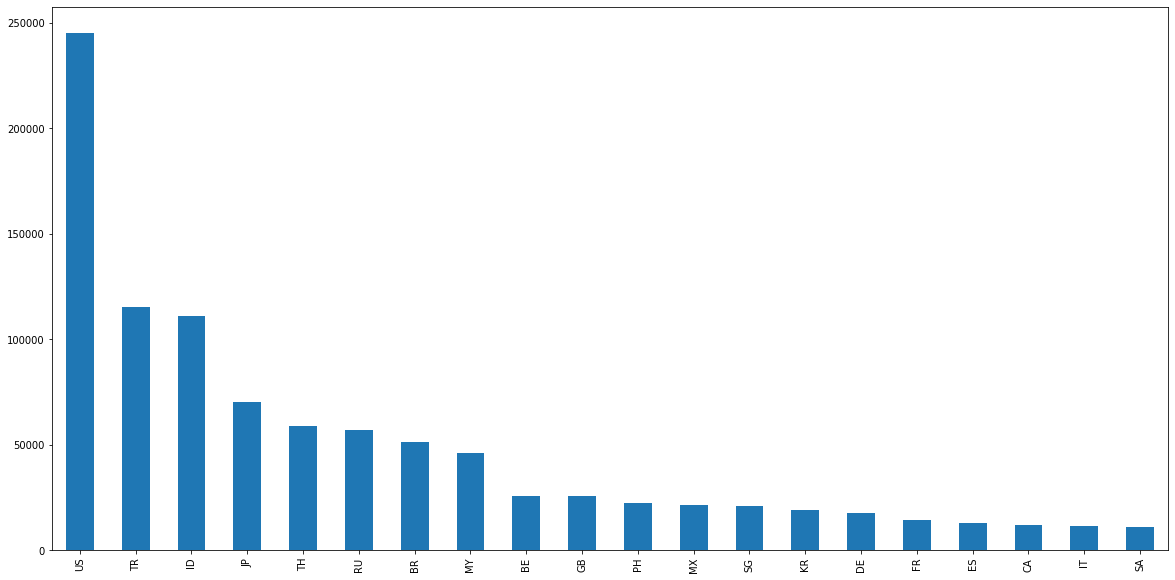

In [ ]:
df_train.country.value_counts()[:20].plot(kind="bar", figsize=(20,10))

In [ ]:
df_train.isna().sum()

id                        0
name                      0
latitude                  0
longitude                 0
address              396620
city                 299188
state                420586
zip                  595425
country                  11
url                  871087
phone                795956
categories            98306
point_of_interest         0
dtype: int64

In [ ]:
## cleaning
print("Null names before cleaning: ", df_train.name.isna().sum())

Null names before cleaning:  1


In [ ]:
## remove punctuations

import re
import string
rem = string.punctuation
pattern = r"[{}]".format(rem)
print(pattern)

[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]


In [ ]:
df_train['name'] = df_train['name'].str.replace(pattern, "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df_train["name"].replace(r'^\s*$', np.nan, regex=True)

0                    Café Stad Oudenaarde
1                          Carioca Manero
2                        ร้านตัดผมการาเกด
3                                Turkcell
4                 Restaurante Casa Cofiño
                        ...              
1138807                              青ガエル
1138808                      Deshon Place
1138809    İzmir Adnan Menderes Havaalanı
1138810                             焼肉 和家
1138811                       Waihi Beach
Name: name, Length: 1138812, dtype: object

In [ ]:
#remove null values
df_train = df_train.dropna(subset=["name"]) 
print("Null names after cleaning: ", df_train.name.isna().sum())

Null names after cleaning:  0


In [ ]:
len(df_train)

1138811

In [ ]:
#remove names with only numbers
df_train_2 = df_train[~df_train['name'].str.isnumeric()]
len(df_train_2)

1138480

In [ ]:
### using ascii to remove non english words lololol

df_train_2 = df_train_2[df_train_2['name'].map(lambda x: x.isascii())]
len(df_train_2)

815857

In [ ]:
print("Number of records removed!:, " , 1138480-815857)
print("Final size of  record: ", len(df_train_2))

Number of records removed!:,  322623
Final size of  record:  815857


### Processing

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 16.7 MB 64.3 MB/s 
     |████████████████████████████████| 6.3 MB 57.4 MB/s 


In [ ]:

from IPython.display import Image, display

In [ ]:
!pip install jellyfish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 6.9 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73983 sha256=dfb2215325d53a3e4f40d8f565734caeb14c70dd0fc4ad440c1dd9fbe0c6f72c
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [ ]:
from jellyfish import jaro_winkler

In [ ]:
import pandas as pd
from collections import Counter
import regex
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
### steps:
## create matching and unmatched pairs
## convert name to similarity score
## find distance between latitude and longiture
## target variable is true/false
## logistic regression

In [ ]:
## try for only CN places
df_cn = df_train_2.loc[df_train.country=="CA"]
df_cn

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
71,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,NaN,NaN,NaN,NaN,CA,NaN,NaN,Delis / Bodegas,P_f0f718416f093d
220,E_000da284c9870c,Cityplace Parade 2,43.640253,-79.397529,21 Iceboat Terrace & 151 Dan Leckie Way,Toronto,ON,M5V 4A9,CA,http://www.cityplace.ca,NaN,Residential Buildings (Apartments / Condos),P_73e9573eae9b55
285,E_0010c637a4855c,Performance MINI,43.180630,-79.250134,266 Lake Street,St Catharines,NaN,NaN,CA,NaN,NaN,Automotive Shops,P_606b4538443c70
440,E_001b8a3c94747a,CHSLD Auclair,45.540000,-73.608702,NaN,Montréal,NaN,NaN,CA,NaN,NaN,"Hospitals, Assisted Living",P_fe99254912e7b6
593,E_0024dfae127c3b,Subway,45.502267,-73.571930,NaN,NaN,NaN,NaN,CA,NaN,NaN,Sandwich Places,P_aae6bf8faf4fc7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138509,E_ffedf8c1e770c3,HM,44.256235,-76.571771,Cataraqui Town Centre,Kingston,NaN,NaN,CA,http://www.hm.com,NaN,Clothing Stores,P_8e48c6f7e64ea2
1138523,E_ffeeb79a4417d7,Red House,43.819223,-79.114072,"705 Kingston Road, Unit 8",Pickering,ON,L1V 6K3,CA,NaN,9054202880,"Thai Restaurants, Malay Restaurants",P_52efb2659ec1c2
1138643,E_fff5e13613780f,St Louis Shopping Centre,45.501600,-73.681196,St. Louis,St-Laurent,QC,NaN,CA,NaN,NaN,Shopping Malls,P_2257249f1e672a
1138758,E_fffd2c84d28468,Lotus Seed Vegetarian,49.232442,-123.024390,"3665 Kingsway, #180",Vancouver,BC,V5R 5W2,CA,http://lotusseed.ca,6044317789,Vegetarian / Vegan Restaurants,P_9e6fb7d11eadc3


In [ ]:
df_cn = df_cn[["id", "name", "latitude", "longitude", "categories",	"point_of_interest"]]

In [ ]:
## creating matching pairs


mathches = pd.merge(df_cn, df_cn, on="point_of_interest", suffixes=('_1', '_2'))
mathches = mathches[mathches["id_1"]!=mathches["id_2"]] ## remove records paired with itself
mathches = mathches.drop(["point_of_interest"], axis=1)
mathches["match"] = True
mathches.head()

,id_1,name_1,latitude_1,longitude_1,categories_1,id_2,name_2,latitude_2,longitude_2,categories_2,match
1,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,True
2,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
3,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True
5,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
6,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True


In [ ]:
mathches.shape

(6928, 11)

In [ ]:
## checking if categories are mismatched -- there are
non_cat = mathches[mathches["categories_1"]!=mathches["categories_2"]]
non_cat

,id_1,name_1,latitude_1,longitude_1,categories_1,id_2,name_2,latitude_2,longitude_2,categories_2,match
2,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
5,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
6,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True
7,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,True
15,E_001b8a3c94747a,CHSLD Auclair,45.540000,-73.608702,"Hospitals, Assisted Living",E_5b06b4a51b292b,Chsld Auclair,45.539610,-73.608315,Assisted Living,True
...,...,...,...,...,...,...,...,...,...,...,...
18070,E_fe4cf3d7822a8f,Bentall Dental,49.286423,-123.120604,Dentist's Offices,E_f4eba4c913ce8a,Bentall Dental Centre,49.286261,-123.120645,"Dentist's Offices, Offices, Buildings",True
18073,E_f4edaad72cbb24,Dawson Dental Centre,44.018674,-79.447578,"Dentist's Offices, Emergency Rooms",E_f8fea270e7d22d,Dawson Dental Centre,44.018771,-79.447500,Dentist's Offices,True
18074,E_f8fea270e7d22d,Dawson Dental Centre,44.018771,-79.447500,Dentist's Offices,E_f4edaad72cbb24,Dawson Dental Centre,44.018674,-79.447578,"Dentist's Offices, Emergency Rooms",True
18227,E_facf6a5d95a4cd,Record Centre,45.402777,-75.725610,"Record Shops, Music Stores",E_fdff85dfbceec3,Audiovideo Centre,45.402653,-75.725886,Music Stores,True


In [ ]:
## creating non-matching pairs

In [ ]:
df_cn_copy = df_cn.copy()
df_cn_copy.index = range(1,len(df_cn)+1)

no_match = pd.concat([df_cn.reset_index().drop(["index"], axis=1).add_suffix('_1'), df_cn_copy.add_suffix('_2')], axis=1)
no_match = no_match.dropna(subset=['point_of_interest_1', 'point_of_interest_2'])
no_match = no_match[no_match['point_of_interest_1'] != no_match['point_of_interest_2']]
no_match = no_match.drop(['point_of_interest_1', 'point_of_interest_2'], axis=1)
no_match['match'] = False

In [ ]:
no_match.head()

,id_1,name_1,latitude_1,longitude_1,categories_1,id_2,name_2,latitude_2,longitude_2,categories_2,match
1,E_000da284c9870c,Cityplace Parade 2,43.640253,-79.397529,Residential Buildings (Apartments / Condos),E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,False
2,E_0010c637a4855c,Performance MINI,43.180630,-79.250134,Automotive Shops,E_000da284c9870c,Cityplace Parade 2,43.640253,-79.397529,Residential Buildings (Apartments / Condos),False
3,E_001b8a3c94747a,CHSLD Auclair,45.540000,-73.608702,"Hospitals, Assisted Living",E_0010c637a4855c,Performance MINI,43.180630,-79.250134,Automotive Shops,False
4,E_0024dfae127c3b,Subway,45.502267,-73.571930,Sandwich Places,E_001b8a3c94747a,CHSLD Auclair,45.540000,-73.608702,"Hospitals, Assisted Living",False
5,E_00320b4648bd37,Olive Garden,53.542428,-113.615984,Italian Restaurants,E_0024dfae127c3b,Subway,45.502267,-73.571930,Sandwich Places,False


In [ ]:
no_match.shape

(11414, 11)

In [ ]:
## join the matched and non-matched together

pairs_df_t = pd.concat([mathches, no_match], axis=0)
pairs_df_t

,id_1,name_1,latitude_1,longitude_1,categories_1,id_2,name_2,latitude_2,longitude_2,categories_2,match
1,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,True
2,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
3,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True
5,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
6,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True
...,...,...,...,...,...,...,...,...,...,...,...
11411,E_ffedf8c1e770c3,HM,44.256235,-76.571771,Clothing Stores,E_ffe67c849e0b01,Dominos Pizza,50.496156,-104.645636,Pizza Places,False
11412,E_ffeeb79a4417d7,Red House,43.819223,-79.114072,"Thai Restaurants, Malay Restaurants",E_ffedf8c1e770c3,HM,44.256235,-76.571771,Clothing Stores,False
11413,E_fff5e13613780f,St Louis Shopping Centre,45.501600,-73.681196,Shopping Malls,E_ffeeb79a4417d7,Red House,43.819223,-79.114072,"Thai Restaurants, Malay Restaurants",False
11414,E_fffd2c84d28468,Lotus Seed Vegetarian,49.232442,-123.024390,Vegetarian / Vegan Restaurants,E_fff5e13613780f,St Louis Shopping Centre,45.501600,-73.681196,Shopping Malls,False


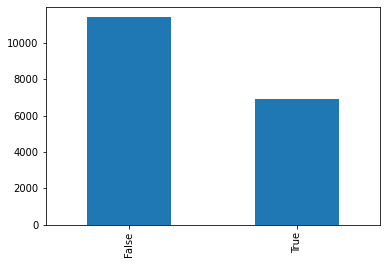

In [ ]:
## checking if dataset is balanced
pairs_df_t["match"].value_counts().plot(kind="bar")

In [ ]:
## since data is kind of imbalanced, resample the data
from sklearn.utils import resample

no_match_downsample = resample(no_match,
             replace=False,
             n_samples=len(mathches),
             random_state=42)

no_match_downsample.shape

(6928, 11)

In [ ]:
### now combine the dataasets
pairs_df = pd.concat([mathches, no_match_downsample], axis=0)
pairs_df

,id_1,name_1,latitude_1,longitude_1,categories_1,id_2,name_2,latitude_2,longitude_2,categories_2,match
1,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,True
2,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
3,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True
5,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,Delis / Bodegas,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",True
6,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,"Butchers, Delis / Bodegas",E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,Delis / Bodegas,True
...,...,...,...,...,...,...,...,...,...,...,...
7682,E_ac802ffd38d546,Dairy Queen Brazier,49.158484,-122.890968,"Fast Food Restaurants, Ice Cream Shops",E_ac7d0bc65b493e,Tofino Trek Inn,49.153634,-125.905358,Bed & Breakfasts,False
4327,E_61f3847527d5b4,Okanagan Mountain Campers Point,49.766588,-119.681775,NaN,E_61ee9a7a6d04f0,MaRS Commons,43.659623,-79.389409,Coworking Spaces,False
4174,E_5e971f4e00d0bc,Sleep Country,43.353404,-79.785962,Mattress Stores,E_5e94966530a244,Niagara College,43.014783,-79.263611,Community Colleges,False
10441,E_ea215cfe27d728,Ruffins pet centre,43.062629,-79.960174,Pet Stores,E_ea1c330d3a4d81,Port Union Waterfront Park,43.774967,-79.134393,"Parks, Trails",False


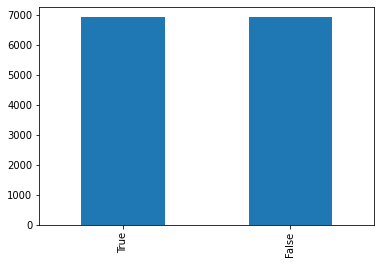

In [ ]:
## checking if dataset is balanced
pairs_df["match"].value_counts().plot(kind="bar")

In [ ]:
len(pairs_df.categories_1.unique())

1612

In [ ]:
### pre processing data
## 1. jaro winkler text similarity on names (emphasis on prefix, edit distances good for names)
## 11 spacy similarity on categories (since these are common words)
## 2. distance b/w points using lat and long (hevenshire something)

In [ ]:
df_preproc = pairs_df.copy()

In [ ]:
!pip install jaro-winkler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 409 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

In [ ]:
import jaro

df_preproc["categories_1"]=df_preproc["categories_1"].replace(","," ")
df_preproc["categories_2"]=df_preproc["categories_2"].replace(","," ")

def get_similarity(x, y):
    nl1=nlp(str(x))
    nl2=nlp(str(y))
    return nl1.similarity(nl2)



df_preproc["name_similarity"] = df_preproc.apply(lambda x: jaro.jaro_winkler_metric(x["name_1"], x["name_2"]), axis=1)  
df_preproc["cat_similarity"] = df_preproc.apply(lambda x: get_similarity(x["categories_1"], x["categories_2"]), axis=1)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if __name__ == '__main__':


In [ ]:
import geopy.distance

df_preproc["distance"] = df_preproc.apply(lambda x: geopy.distance.geodesic((x['latitude_1'], x['longitude_1']), (x['latitude_2'], x['longitude_2'])).km, axis=1)
df_preproc["distance"]

1           0.098623
2           0.097405
3           0.098623
5           0.003798
6           0.097405
            ...     
7682      219.864500
4327     3114.960812
4174       56.732128
10441     103.612236
4552      521.275062
Name: distance, Length: 13856, dtype: float64

In [ ]:
df_preproc[['name_similarity', 'cat_similarity', 'distance', 'match']]

,name_similarity,cat_similarity,distance,match
1,0.925926,1.000000,0.098623,True
2,0.705387,0.840561,0.097405,True
3,0.925926,1.000000,0.098623,True
5,0.840404,0.840561,0.003798,True
6,0.705387,0.840561,0.097405,True
...,...,...,...,...
7682,0.516374,0.578750,219.864500,False
4327,0.555556,-0.094642,3114.960812,False
4174,0.358120,0.361549,56.732128,False
10441,0.504274,0.290724,103.612236,False


In [ ]:
### modelling
from sklearn.model_selection import train_test_split

X = df_preproc[['name_similarity', 'cat_similarity', 'distance']]
y = df_preproc[["match"]]

#scaling
scaler = MinMaxScaler()
scaler = scaler.fit(X) 
scaled_train = scaler.fit_transform(X)

## splitting into train test and validation
X_train, X_test, y_train, y_test = train_test_split(scaled_train, y, test_size=0.2, random_state=1)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
val_prediction = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.9621212121212122

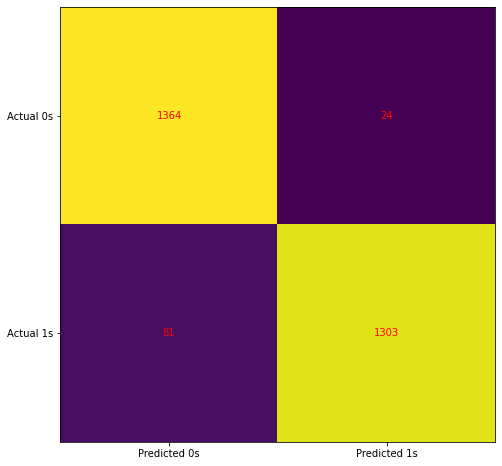

In [ ]:
cm = confusion_matrix(y_test, val_prediction)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
### on actual pairs data

df__new__test = df_pairs.loc[df_pairs["country_1"]=="PH"]
df__new__test


,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False
71,E_0009fe536d869a,Minute Burger,8.228528,124.240768,Quezon Ave Ext,Iligan City,Northern Mindanao,9211,PH,NaN,...,124.240769,Poblacion,Iligan City,Northern Mindanao,9200,PH,NaN,27767740,Burger Joints,True
148,E_0014cc26aec0ed,iStudio,14.589482,120.983781,"Lower Ground SM City Manila, Concepcion",Manila,Metro Manila,NaN,PH,NaN,...,120.984408,NaN,Manila,Metro Manila,NaN,PH,NaN,NaN,Electronics Stores,True
218,E_001eeb59c7d4b6,David's Salon,14.578699,121.046290,NaN,Mandaluyong City,Metro Manila,1550,PH,NaN,...,121.054519,Shangri-la Mall,Mandaluyong City,Metro Manila,NaN,PH,NaN,NaN,"Salons / Barbershops, Cosmetics Shops",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578864,E_fffa4a022b1a65,Cafe Bob's,14.535262,120.979658,21st Lacson St.,Bacolod City,NaN,6100,PH,NaN,...,120.980302,"Ground Flr, SM Mall of Asia (Entertainment Mall)",Pasay City,Metro Manila,NaN,PH,http://www.boscoffee.com,NaN,"Coffee Shops, Cafés",False
578869,E_fffac1b40d3a32,McDonald's,14.657787,121.020466,Epifanio delos Santos Ave,Quezon City,Metro Manila,NaN,PH,NaN,...,121.019609,NaN,NaN,NaN,NaN,PH,NaN,NaN,Fast Food Restaurants,True
578870,E_fffac1b40d3a32,McDonald's,14.657787,121.020466,Epifanio delos Santos Ave,Quezon City,Metro Manila,NaN,PH,NaN,...,121.030954,"Ground Flr, SM City North EDSA",Quezon City,Metro Manila,1105,PH,NaN,NaN,Fast Food Restaurants,False
578871,E_fffac1b40d3a32,McDonald's,14.657787,121.020466,Epifanio delos Santos Ave,Quezon City,Metro Manila,NaN,PH,NaN,...,121.018209,NaN,NaN,NaN,NaN,PH,NaN,NaN,Fast Food Restaurants,True


In [ ]:
df__new__test["categories_1"]=df__new__test["categories_1"].replace(","," ")
df__new__test["categories_2"]=df__new__test["categories_2"].replace(","," ")


df__new__test["name_similarity"] = df__new__test.apply(lambda x: jaro.jaro_winkler_metric(x["name_1"], x["name_2"]), axis=1)  
df__new__test["cat_similarity"] = df__new__test.apply(lambda x: get_similarity(x["categories_1"], x["categories_2"]), axis=1)  

df__new__test["distance"] = df__new__test.apply(lambda x: geopy.distance.geodesic((x['latitude_1'], x['longitude_1']), (x['latitude_2'], x['longitude_2'])).km, axis=1)
df__new__test["distance"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

2         0.140466
4         0.698792
71        0.000613
148       0.073408
218       0.909646
            ...   
578864    0.069540
578869    0.092826
578870    1.139350
578871    0.244049
578894    0.277572
Name: distance, Length: 12153, dtype: float64

In [ ]:
new_X = scaler.fit_transform(df__new__test[['name_similarity', 'cat_similarity', 'distance']])
new_y = df__new__test[["match"]]

In [ ]:
new_X

array([[9.11111111e-01, 9.99999918e-01, 1.02437629e-05],
       [9.37777778e-01, 9.79696884e-01, 5.09607484e-05],
       [1.00000000e+00, 9.99999918e-01, 4.46934857e-08],
       ...,
       [1.00000000e+00, 9.99999918e-01, 8.30892958e-05],
       [9.25000000e-01, 9.99999918e-01, 1.77977492e-05],
       [1.00000000e+00, 9.99999918e-01, 2.02424432e-05]])

In [ ]:
new_prediction = model.predict(new_X)
new_prediction

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
model.score(new_X, new_y)

0.7646671603719246

#### on df_test dataset

In [ ]:
## pre process the data

## generate by country
## 2 methods
### closest by location - 5km
### closest by text matching

In [ ]:
df_test.iloc[0]

id                   E_00001118ad0191
name          Jamu Petani Bagan Serai
latitude                     5.012169
longitude                  100.535805
address                           NaN
city                              NaN
state                             NaN
zip                               NaN
country                            MY
url                               NaN
phone                             NaN
categories                      Cafés
Name: 0, dtype: object

In [ ]:
from sklearn.preprocessing import MinMaxScaler

submit_list = list()
submit_list_ac = list()
no_match_id = list()
for i in range(0, len(df_test)):


  test_id = df_test.iloc[i,0]
  test_name = df_test.iloc[i,1]
  test_lat = df_test.iloc[i,2]
  test_long= df_test.iloc[i,3]
  test_cat = df_test.iloc[i,11]
  test_country = df_test.iloc[i,8]

  print(test_country, test_cat)

  df_test_loc = df_train.loc[df_train.country==test_country]

  df_test_loc["name_similarity"] = df_test_loc.apply(lambda x: jaro.jaro_winkler_metric(x["name"], test_name), axis=1)  
  df_test_loc["distance"] =  df_test_loc.apply(lambda x: geopy.distance.geodesic((x['latitude'], x['longitude']), (test_lat, test_long)).km, axis=1)

  df_loc = df_test_loc.loc[(df_test_loc["distance"]<5) & (df_test_loc["name_similarity"]>0.7)]

  if(df_loc.empty):
    no_match_id.append(test_id)

  else:
    df_loc["cat_similarity"] = df_loc.apply(lambda x: get_similarity(x["categories"], test_cat), axis=1)  

    scaled = scaler.fit_transform(df_loc[['name_similarity', 'cat_similarity', 'distance']])
    

    pred = model.predict(scaled)

    df_loc["pred"] = pred
    fin = df_loc.loc[df_loc["pred"]==True]

    if(fin.empty):
      print("no matches!", test_id)
      no_match_id.append(test_id)

    else:
      for i in fin["id"].unique():
        submit_list.append(i)
      for i in fin["id"]:
        submit_list_ac.append(test_id)

MY Cafés


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

US Bars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RU ATMs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

no matches! E_00002f98667edf
ID Stadiums


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

ID Soccer Stadiums


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
pd.DataFrame(submit_list, submit_list_ac)

,0
E_00001118ad0191,E_5be051889de601
E_001b6bad66eb98,E_161706a74b5308
E_0283d9f61e569d,E_219bdfd88b5241
E_0283d9f61e569d,E_6e477dd29c2dc2


In [ ]:
no_match_id

['E_000020eb6fed40', 'E_00002f98667edf']

In [ ]:
df_test

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434209,-80.564160,497 N 12th St,Weirton,WV,26062.0,US,NaN,NaN,Bars
2,E_00002f98667edf,QIWI,47.215134,39.686088,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,7.800301e+10,ATMs
3,E_001b6bad66eb98,"Gelora Sriwijaya, Jaka Baring Sport City",-3.014675,104.794374,NaN,NaN,NaN,NaN,ID,NaN,NaN,Stadiums
4,E_0283d9f61e569d,Stadion Gelora Sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,Soccer Stadiums


In [ ]:
## get all the similar countries
i=1
test_id = df_test.iloc[i,0]
test_name = df_test.iloc[i,1]
test_lat = df_test.iloc[i,2]
test_long= df_test.iloc[i,3]
test_cat = df_test.iloc[i,11]
test_country = df_test.iloc[i,8]
df_test_loc = df_train.loc[df_train.country==test_country]

In [ ]:
df_test_loc

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
8,E_00007dcd2bb53f,TOGOS Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,7074394747,Sandwich Places,P_aae7505da98d46
13,E_0000d9e584ed9f,Signature Properties Savannah,32.012582,-81.113156,100 Commercial Ct Ste C,Savannah,GA,31406,US,http://www.oursignatureproperties.com,9126292700,Real Estate Offices,P_af856e3abdcebc
16,E_00011cca3f0bd6,Inner Workings,35.686930,-105.939167,Serving General Area,Santa Fe,NM,87501,US,http://innerworkingsmassage.com,(505) 850-0872,Massage Studios,P_ea131770ce8f01
19,E_00015cd7e0227f,Lake Destiny,28.643613,-81.389132,NaN,Maitland,FL,32751,US,NaN,NaN,Lakes,P_dc0c160f3fcef8
23,E_0001968548bde2,Champion,33.884938,-84.269151,3700 Dekalb Technology Pkwy,Atlanta,GA,30340,US,NaN,NaN,NaN,P_2dd4afac52e8b8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138789,E_fffe88fc908438,Jerns Funeral Chapel,48.770252,-122.463114,800 E Sunset Dr,Bellingham,WA,98225,US,NaN,+13607340070,Funeral Homes,P_9d7d732431075d
1138797,E_ffff59c16a4c36,Walgreens,38.714765,-90.453349,12509 Dorsett Rd,Maryland Heights,MO,63043,US,https://www.walgreens.com/locator/walgreens-12...,3144344224,"Pharmacies, Convenience Stores, Photography Labs",P_525103ba9777c2
1138798,E_ffff62eb945bd0,Mi Casita,48.531865,-123.023560,NaN,Friday Harbor,WA,98250,US,NaN,NaN,Bars,P_af5567d03a4472
1138806,E_ffff989ae206f8,Cricket Wireless Authorized Retailer,36.130623,-86.715636,825C Murfreesboro Pike,Nashville,TN,37217,US,https://www.cricketwireless.com/stores/ll/US/T...,+16156799940,Mobile Phone Shops,P_caad31263268d4


In [ ]:
df_test_loc["name_similarity"] = df_test_loc.apply(lambda x: jaro.jaro_winkler_metric(x["name"], test_name), axis=1)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test_loc["distance"] =  df_test_loc.apply(lambda x: geopy.distance.geodesic((x['latitude'], x['longitude']), (test_lat, test_long)).km, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test_loc["distance"].min()

2.5718080460051604

In [ ]:
## select the distances within 5km

df_loc = df_test_loc.loc[(df_test_loc["distance"]<50) & (df_test_loc["name_similarity"]>0.7)]
df_loc

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,name_similarity,distance
26505,E_05f1a1bb6ce29a,Anthonys Barber Stylist,40.529905,-80.009858,4847-4901 U.S. 19 Truck,Pittsburgh,PA,15237,US,NaN,NaN,"Salons / Barbershops, Cosmetics Shops, Miscell...",P_f7ddd3ff99bd29,0.716667,48.185689
935873,E_d23968ed099f45,Anthonys Barber Shop,40.529697,-80.010085,4885 McKnight Rd,Pittsburgh,PA,15237,US,NaN,+14123661155,"Salons / Barbershops, Cosmetics Shops, Miscell...",P_f7ddd3ff99bd29,0.744444,48.161927


In [ ]:
df_loc["cat_similarity"] = df_loc.apply(lambda x: get_similarity(x["categories"], test_cat), axis=1)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_loc[['name_similarity', 'cat_similarity', 'distance']])
scaled

array([[0.14444686, 0.        , 0.29277661],
       [0.73087982, 0.88364464, 0.11334547],
       [0.14444686, 0.        , 0.1700239 ],
       [0.        , 0.39174699, 0.09736015],
       [1.        , 1.        , 0.        ],
       [0.14444686, 0.        , 0.65930269],
       [0.14444686, 0.        , 0.8008782 ],
       [0.14444686, 0.37065929, 0.14518031],
       [0.14444686, 0.        , 0.69740514],
       [0.14444686, 0.        , 0.02968643],
       [0.59637046, 0.88364464, 1.        ]])

In [ ]:
#modelling

df_loc_X = df_loc[['name_similarity', 'cat_similarity', 'distance']]

In [ ]:
pred = model.predict(scaled)
pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


array([False,  True, False, False,  True, False, False, False, False,
       False,  True])

In [ ]:
df_test

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434209,-80.564160,497 N 12th St,Weirton,WV,26062.0,US,NaN,NaN,Bars
2,E_00002f98667edf,QIWI,47.215134,39.686088,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,7.800301e+10,ATMs
3,E_001b6bad66eb98,"Gelora Sriwijaya, Jaka Baring Sport City",-3.014675,104.794374,NaN,NaN,NaN,NaN,ID,NaN,NaN,Stadiums
4,E_0283d9f61e569d,Stadion Gelora Sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,Soccer Stadiums


In [ ]:
df_loc["pred"] = pred
fin = df_loc.loc[df_loc["pred"]==True]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tt=list()
tt.append(fin["id"].unique())
tt

[array(['E_219bdfd88b5241', 'E_6e477dd29c2dc2', 'E_f5e3c90135fbb9'],
       dtype=object)]

## Random Nonsense

In [ ]:
#######################################################

In [ ]:
def sequence_uniqueness(seq, token2frequency):
    return sum(1/token2frequency[t]**0.5 for t in seq)

def name_similarity(a, b, token2frequency):
    a_tokens = set(a)
    b_tokens = set(b)
    a_uniq = sequence_uniqueness(a, token2frequency)
    b_uniq = sequence_uniqueness(b, token2frequency)
    if a_uniq==0 or b_uniq == 0:
        return 0
    else:
        return sequence_uniqueness(a_tokens.intersection(b_tokens), token2frequency)/(a_uniq * b_uniq) ** 0.5


def parse_name(name):
    name = regex.sub(r"[[:punct:]]+", "", name)
    tokens = nltk.word_tokenize(name) 
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english')] 
    return tokens

def build_token2frequency(names):
    alltokens = []
    for tokens in names.values():
        alltokens += tokens

    return Counter(alltokens)

In [ ]:
df_train_2.country.unique()

array(['BR', 'TR', 'PH', 'KW', 'ID', 'US', 'DE', 'SA', 'MY', 'IT', 'FR',
       'BE', 'PT', 'EG', 'MX', 'TH', 'KR', 'MV', 'ZA', 'CL', 'HU', 'CA',
       'SG', 'FI', 'RO', 'GB', 'PL', 'CH', 'JP', 'RS', 'AR', 'RU', 'KH',
       'AT', 'IN', 'ES', 'TW', 'PY', 'DO', 'VE', 'PE', 'IE', 'XX', 'MW',
       'CZ', 'NL', 'AU', 'LV', 'PR', 'BY', 'HK', 'GR', 'SK', 'GE', 'IR',
       'AG', 'VN', 'AE', 'CO', 'MU', 'ME', 'UA', 'IL', 'DK', 'CR', 'NZ',
       'MT', 'KE', 'BG', 'CN', 'PF', 'PA', 'SE', 'BT', 'SI', 'CW', 'AL',
       'LB', 'NO', 'EE', 'BN', 'LU', 'FJ', 'MD', 'LT', 'TT', 'LA', 'QA',
       'HR', 'CY', 'BH', 'MK', 'RW', 'SV', 'GH', 'EC', 'MQ', 'PK', 'UY',
       'SR', 'JM', 'MA', 'ZM', 'JO', 'AM', 'AW', 'MO', 'BS', 'SY', 'UZ',
       'LK', 'GU', 'GT', 'RE', 'NI', 'BO', 'IM', 'TN', 'CU', 'BB', 'IS',
       'NP', 'OM', 'NG', 'HN', 'KY', 'UG', 'MN', 'BD', 'ET', 'MC', 'KZ',
       'MG', 'SD', 'KP', 'DZ', 'AZ', 'BL', 'WS', 'HT', 'MZ', 'TC', 'YE',
       'BA', 'CV', 'IQ', 'BZ', 'PG', 'KG', 'CI', 'B

In [ ]:
## try for only US places
df_us = df_train_2.loc[df_train.country=="CA"]
df_us.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
71,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,NaN,NaN,NaN,NaN,CA,NaN,NaN,Delis / Bodegas,P_f0f718416f093d
220,E_000da284c9870c,Cityplace Parade 2,43.640253,-79.397529,21 Iceboat Terrace & 151 Dan Leckie Way,Toronto,ON,M5V 4A9,CA,http://www.cityplace.ca,NaN,Residential Buildings (Apartments / Condos),P_73e9573eae9b55
285,E_0010c637a4855c,Performance MINI,43.180630,-79.250134,266 Lake Street,St Catharines,NaN,NaN,CA,NaN,NaN,Automotive Shops,P_606b4538443c70
440,E_001b8a3c94747a,CHSLD Auclair,45.540000,-73.608702,NaN,Montréal,NaN,NaN,CA,NaN,NaN,"Hospitals, Assisted Living",P_fe99254912e7b6
593,E_0024dfae127c3b,Subway,45.502267,-73.571930,NaN,NaN,NaN,NaN,CA,NaN,NaN,Sandwich Places,P_aae6bf8faf4fc7


In [ ]:
import nltk
nltk.download('punkt')

names_us = df_us.name.dropna().unique()
parsed_names = {name:parse_name(name) for name in names_us}
token2frequency = build_token2frequency(parsed_names)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


AttributeError: ignored

In [ ]:
grouping = {}
for name, tokens in parsed_names.items():
    grouping[name] = {name2: name_similarity(tokens, tokens2, token2frequency) for name2, tokens2 in parsed_names.items()}


In [ ]:
grouping.keys()

dict_keys(['boucherie sthelene', 'Cityplace Parade 2', 'Performance MINI', 'CHSLD Auclair', 'Subway', 'Olive Garden', 'CF Toronto Eaton Centre', 'Dollys Fish Market', 'Stephen Ave Mall', 'Chevron', 'Verger Belliveau Orchard', 'Canadian Tire', 'Liquor Depot Southland Crossing', 'Bourbon Court', 'UQTR  Pavillon Chiropratique', 'Lively High', 'HighRisk Obstetrical Unit Sunnybrook', 'Fern Hill Cemetery', 'Double Pizza', 'Quesada', 'GoodLife Fitness Georgetown Sinclair and Guelph', 'Pioneer Energy', 'Taxi 02440', 'Odette Coiffure', 'Abbey Antiques  Art', 'Houston Avenue Bar  Grill', 'Green P', 'Bentley', 'Sears Home Store', 'Edward Jones  Financial Advisor Tom Kinred', 'Iris Dentistry', 'Tide  Boar Gastropub', 'National Sports', 'old time confections', 'Douglas College New Westminster Campus', 'Ferris Oyster Bar  Grill', 'wallmart Oshawa', 'Indochino', 'The Source', 'HM', 'Fantini PSC 2', 'Zaza Espresso Bar  Gelato', 'vehicle deck 4 Costal Celebration BC Ferry', 'Starbucks Wall Centre', 'Ze

In [ ]:
grouping["boucherie sthelene"]

{'boucherie sthelene': 1.0,
 'Cityplace Parade 2': 0.0,
 'Performance MINI': 0.0,
 'CHSLD Auclair': 0.0,
 'Subway': 0.0,
 'Olive Garden': 0.0,
 'CF Toronto Eaton Centre': 0.0,
 'Dollys Fish Market': 0.0,
 'Stephen Ave Mall': 0.0,
 'Chevron': 0.0,
 'Verger Belliveau Orchard': 0.0,
 'Canadian Tire': 0.0,
 'Liquor Depot Southland Crossing': 0.0,
 'Bourbon Court': 0.0,
 'UQTR  Pavillon Chiropratique': 0.0,
 'Lively High': 0.0,
 'HighRisk Obstetrical Unit Sunnybrook': 0.0,
 'Fern Hill Cemetery': 0.0,
 'Double Pizza': 0.0,
 'Quesada': 0.0,
 'GoodLife Fitness Georgetown Sinclair and Guelph': 0.0,
 'Pioneer Energy': 0.0,
 'Taxi 02440': 0.0,
 'Odette Coiffure': 0.0,
 'Abbey Antiques  Art': 0.0,
 'Houston Avenue Bar  Grill': 0.0,
 'Green P': 0.0,
 'Bentley': 0.0,
 'Sears Home Store': 0.0,
 'Edward Jones  Financial Advisor Tom Kinred': 0.0,
 'Iris Dentistry': 0.0,
 'Tide  Boar Gastropub': 0.0,
 'National Sports': 0.0,
 'old time confections': 0.0,
 'Douglas College New Westminster Campus': 0.0,
 

In [ ]:
df_pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


In [ ]:
import copy

grouping_list = grouping.copy()

In [ ]:
i_poi = df_us.loc[df_us["name"]=="Subway", "point_of_interest"]
i_poi

593        P_aae6bf8faf4fc7
4769       P_6d4baa4d87fc92
7368       P_2a4d25b2c0f3e4
32221      P_bfaea18592374c
41636      P_73c02d3b8308d7
                 ...       
1087132    P_62c2fd8011e2c4
1091297    P_917effaede6308
1091709    P_d5b50b0456a35b
1104574    P_c0f1c320b128b2
1104834    P_d889de00d2496a
Name: point_of_interest, Length: 122, dtype: object

In [ ]:
def get_max_score(text_score):
  d = dict((k, v) for k, v in text_score.items() if (v > 0) & (v<1))
  k_temp, v_temp = "", ""
  if d:
      k_temp = max(d, key=d.get)
      v_temp  = d[k_temp]
  
  return k_temp, v_temp


flag = True

name_1 = list()
name_2 = list()
score = list()
popped_words = list ()
no_match = list()

count = 0
for i in grouping_list:
  flag=True
  print("Running for: ", i)
  poi_len=2
  i_poi = df_us.loc[df_us["name"]==i, "point_of_interest"]
  if(len(i_poi)==1):
    poi_len = len(df_us.loc[df_us["point_of_interest"]==i_poi.item()])
  if((i not in popped_words) & (poi_len>1)):
    j = grouping_list[i]
    
    while(flag):
        k_temp, v_temp = get_max_score(j)
        if(k_temp!=""):
          ## first check if the high score is same for the other token
          j_check = grouping_list[k_temp]
          k_check, v_check = get_max_score(j_check)
          if(k_check == k_temp):
            print("success! same matches")
            print(k_check)

            ## add to list
            name_1.append(k_temp)
            name_2.append(k_check)
            score.append(max(v_check, v_temp))

            ## delete both records from grouping_list
            #grouping_list.pop(k_temp)
            popped_words.append(k_temp)

            flag=False
          
          else:
            print("wrong matches!!.. continue searching")
            print(k_temp)
            print(k_check)
            tt=j.pop(k_temp)
            print("removed: ", tt)

        else:
          print("no match found")
          no_match.append(i)
          flag=False
    
  else:
    print("already matched earlier: ", i)
    print("or only 1 poi present..:", poi_len)
    if(poi_len<2):
      no_match.append(i)

          



Streaming output truncated to the last 5000 lines.
removed:  0.10855710348906619
wrong matches!!.. continue searching
Theatre Centre Cafe
College Theatre
removed:  0.10837588678302593
wrong matches!!.. continue searching
Chinook Centre
Sun Life Financial Calgary Chinook
removed:  0.10795400421176704
wrong matches!!.. continue searching
Canadian Tire Centre
Canadian Tire
removed:  0.10702029843752829
wrong matches!!.. continue searching
Southgate Centre
Durham College Fitness Centre
removed:  0.10483708528778933
wrong matches!!.. continue searching
Mission Centre
Mission Creek Orthodontics
removed:  0.1013212755879191
wrong matches!!.. continue searching
Scotiabank Centre
Scotiabank
removed:  0.1013212755879191
wrong matches!!.. continue searching
West Vancouver Community Centre
Vancouver Convention Centre West
removed:  0.0986191158870063
wrong matches!!.. continue searching
Edmonton City Centre
Edmonton airport
removed:  0.09824281729980887
wrong matches!!.. continue searching
Wall Ce

In [ ]:
df_sim = pd.DataFrame(list(zip(name_1, name_2, score)),
               columns =['name_1', 'name_2', "score"])

In [ ]:
df_sim.tail(7)

,name_1,name_2,score
2174,Fort William Historical Park,Fort William Historical Park,1.000000
2175,Upper Yonge Dental,Upper Yonge Dental,1.000000
2176,NAPA Auto Parts NAPA Whitby,NAPA Auto Parts NAPA Whitby,0.811632
2177,Lions Gate Appliance Services,Lions Gate Appliance Services,1.000000
2178,The Bbq At Kane Ave,The Bbq At Kane Ave,1.000000
2179,Thi Thi Vietnamese Submarine,Thi Thi Vietnamese Submarine,0.730248
2180,Red Bean Waffle House,Red Bean Waffle House,1.000000


In [ ]:
g1 = grouping["North West House at Fort William Historical Park"]

d = dict((k, v) for k, v in g1.items() if (v > 0.5) & (v<1))
d

df_us.loc[df_us["name"]=="Fort William Historical Park"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
660922,E_9481f9c5e4f62e,Fort William Historical Park,48.34719,-89.35476,1350 King Road,Thunder Bay,ON,P7K 1L7,CA,http://fwhp.ca,8075778461,Other Great Outdoors,P_f509fb7aadaf35


In [ ]:
df_us.loc[df_us["name"]=="North West House at Fort William Historical Park"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
29038,E_0681d41c5abbb8,North West House at Fort William Historical Park,48.343115,-89.358265,1350 King Road,Thunder Bay,Ontario,P7K 1L7,CA,NaN,8074732344,Historic Sites,P_8dd97062afc3d7


In [ ]:
  i_cat = df_us.loc[df_us["name"]==i, categories]
  for k2, v2 in d.items():

    if
    df_us.loc[df_us["name"]=="Boucherie stheleme",  "categories"]

  

  if d:
    k=max(d, key=d.get)
    v = d[k]
    print(k)
    print(v)
    print("\n")

In [ ]:
g1 = grouping["boucherie sthelene"]

d = dict((k, v) for k, v in g1.items() if (v > 0) & (v<1))
d

{}

In [ ]:
g1 = grouping["Boucherie BeauBien"]

d = dict((k, v) for k, v in g1.items() if (v > 0) & (v<1))
d

{}

In [ ]:
df_us.loc[df_us["name"]=="Boucherie stheleme"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
1071270,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,NaN,NaN,NaN,NaN,CA,NaN,NaN,Delis / Bodegas,P_f0f718416f093d


In [ ]:
df_us.loc[df_us["name"]=="Boucherie BeauBien"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
773978,E_add5fcf4c56755,Boucherie BeauBien,45.546811,-73.543749,"3748, rue Ontario Est",Montréal,QC,H1W 1S2,CA,http://www.boucherie-beau-bien.ca,5145270221,Butchers,P_9eef0f23e9493a


In [ ]:
df_us.loc[df_us["point_of_interest"]=="P_f0f718416f093d"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
71,E_00047a8d86d71d,boucherie sthelene,45.514784,-73.490114,NaN,NaN,NaN,NaN,CA,NaN,NaN,Delis / Bodegas,P_f0f718416f093d
1071270,E_f0c3574a00b19e,Boucherie stheleme,45.514492,-73.488922,NaN,NaN,NaN,NaN,CA,NaN,NaN,Delis / Bodegas,P_f0f718416f093d
1121020,E_fc02d163ca1904,Boucherie Fruiterie MarieVictorin,45.514465,-73.488953,NaN,NaN,NaN,NaN,CA,NaN,NaN,"Butchers, Delis / Bodegas",P_f0f718416f093d


In [ ]:
## extract the highest similarity from the process and put that as the similarity score



#### to check on what basis POI is done

In [ ]:
poi = df_train.groupby('point_of_interest').filter(lambda x: True)
poi

KeyboardInterrupt: ignored

In [ ]:
df_train.point_of_interest.value_counts()[:15]




P_fb339198a31db3    332
P_3a3fbd26e16269    199
P_f70a0977377171    166
P_9290e406eb58ac    145
P_fbe61733fcdebe    132
P_59cb47cbf3a432    130
P_f82d146eaf21da    120
P_40323f7f948c18    120
P_f8a0cd160eec80    119
P_6c385e5fd3a4b7    119
P_35db41d5e6fe17    115
P_9ca6f5784b5b37    115
P_16f3e1dfab51fa    106
P_ed155db12f35d7    105
P_bee1aae475d656    103
Name: point_of_interest, dtype: int64

In [ ]:
df_train.loc[df_train.point_of_interest =="P_ed155db12f35d7"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
7997,E_01d080572a6b8e,Ngurah Rai Airport,-6.138658,106.253418,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7
15512,E_03813c7393c019,Bandar Udara Internasional Ngurah Rai,-5.076035,119.547617,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7
35566,E_07f834454faea5,I Gusti Ngurah Rai International Airport,-8.819983,115.148094,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7
45911,E_0a45c563c13e07,Ngura Rai International Airport,-5.170630,119.450354,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7
49585,E_0b15a8b5e3056f,Ngurah Rai International Airport,-8.495928,115.445633,Bypass,Denpasar,Denpasar,NaN,ID,NaN,NaN,Airport Terminals,P_ed155db12f35d7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102821,E_f7df13d69ac19f,Bandara Ngurah Rai,-6.200611,106.850999,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7
1103940,E_f82157d4f6d4e3,Bandar Udara International Ngurah Rai (DPS),-7.463066,110.971757,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7
1106261,E_f8a7673f11e8e3,Bandara Internasional Ngurahrai Bali,-8.744589,115.168035,Bali,Bali,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_ed155db12f35d7
1108880,E_f93e533278a167,Ngurah Rai International Airport,-8.706231,115.196352,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ed155db12f35d7


In [ ]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "-8.459931,	118.736602	"
location = locator.reverse(coordinates)
location.raw

{'address': {'ISO3166-2-lvl4': 'ID-NB',
  'city': 'Bima',
  'country': 'Indonesia',
  'country_code': 'id',
  'hamlet': 'Kantor Kelurahan Monggonao',
  'postcode': '84119',
  'road': 'Jalan Jambu',
  'shop': 'Percetakan',
  'state': 'Nusa Tenggara Barat'},
 'boundingbox': ['-8.4599782', '-8.4598782', '118.7365065', '118.7366065'],
 'display_name': 'Percetakan, Jalan Jambu, Kantor Kelurahan Monggonao, Bima, Nusa Tenggara Barat, 84119, Indonesia',
 'lat': '-8.4599282',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '118.7365565',
 'osm_id': 3641007069,
 'osm_type': 'node',
 'place_id': 43858227}

In [ ]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "-8.744589	115.168035	"
location = locator.reverse(coordinates)
location.raw

{'address': {'ISO3166-2-lvl4': 'ID-BA',
  'aeroway': 'Bandar Udara Internasional Ngurah Rai',
  'city': 'Denpasar',
  'country': 'Indonesia',
  'country_code': 'id',
  'municipality': 'Kuta',
  'postcode': '80362',
  'road': 'Jalan Masjapur',
  'state': 'Bali'},
 'boundingbox': ['-8.7520536', '-8.7399', '115.1519477', '115.182728'],
 'display_name': 'Bandar Udara Internasional Ngurah Rai, Jalan Masjapur, Denpasar, Kuta, Bali, 80362, Indonesia',
 'lat': '-8.7458582',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '115.16733897840365',
 'osm_id': 82162575,
 'osm_type': 'way',
 'place_id': 124563598}

In [ ]:
df_train.loc[df_train.country=="US"]

df_train.loc[df_train.point_of_interest =="P_399ab9d64f2a2e"]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
1517,E_005b1a6f97ca7b,Nationwide Insurance,39.962014,-82.885847,583 S Yearling Rd,Columbus,OH,43213,US,http://t.co/4eDIQ4ptQn,+16145752643,Financial or Legal Services,P_399ab9d64f2a2e
18038,E_040fc0ba3c8f99,Nationwide Insurance - Donald W. Hughes,30.656372,-97.000563,223 Ackerman St,Rockdale,TX,76567,US,http://t.co/4eDIQ4ptQn,+15124460044,Financial or Legal Services,P_399ab9d64f2a2e
43834,E_09d1216a7db5b8,Nationwide Insurance - Mclane Insurance Agency...,41.819975,-71.428859,335 Broadway,Providence,RI,02909,US,http://t.co/4eDIQ4ptQn,+14014531411,Financial or Legal Services,P_399ab9d64f2a2e
52883,E_0bd73612458a65,Nationwide Insurance - Ronald Scott Madden Agency,36.828552,-119.701050,150 Clovis Ave,Clovis,CA,93612,US,http://t.co/4eDIQ4ptQn,+15594723920,Financial or Legal Services,P_399ab9d64f2a2e
128784,E_1cde0c27d20fa3,Nationwide Insurance - Larry Cole Insurance Inc,33.798924,-83.703632,702 E Spring St,Monroe,GA,30655,US,http://agency.nationwide.com/agent/larry-o-col...,7702673212,Financial or Legal Services,P_399ab9d64f2a2e
147100,E_20fbc6aaa6943d,Nationwide Insurance,35.991922,-80.028573,120 W Lexington Ave,High Point,NC,27262,US,http://agency.nationwide.com/agent/larry-e-bro...,+13368882525,Financial or Legal Services,P_399ab9d64f2a2e
161948,E_244e1f268f7faa,Nationwide Insurance - Bruce Sargent Insurance...,34.262962,-92.084663,7300 Dollarway Rd,White Hall,AR,71602,US,http://t.co/4eDIQ4ptQn,+18702478300,Financial or Legal Services,P_399ab9d64f2a2e
168419,E_25c36512baaa40,Nationwide Insurance - James Bialek,38.711374,-80.657459,2434 Sutton Ln Flatwoods,Sutton,WV,26601,US,http://t.co/4eDIQ4ptQn,+13047657388,Financial or Legal Services,P_399ab9d64f2a2e
170978,E_2653165e890ef2,Nationwide Insurance - Braun Ins Agency Inc,36.811922,-76.203795,6062 Indian River Rd,Virginia Beach,VA,23464,US,http://t.co/4eDIQ4ptQn,+17574200696,Financial or Legal Services,P_399ab9d64f2a2e
178839,E_281e0f810f4fbc,Nationwide Insurance - James S Wills Agency,34.002866,-81.772301,207 N Main St,Saluda,SC,29138,US,http://t.co/4eDIQ4ptQn,+18644457113,Financial or Legal Services,P_399ab9d64f2a2e


In [ ]:
df_train.loc[df_train.country=="US"].point_of_interest.value_counts()[:15]

P_399ab9d64f2a2e    58
P_ce9291000a8f0b    46
P_a3fddc2f0a77e7    37
P_d89437d5f1169c    35
P_5cf56bf7bdf7ae    29
P_fff25ec89e22da    28
P_0c880e80aaa19f    26
P_bae8584591fe1a    26
P_1e8e17b542e178    25
P_4efd9da6085caf    25
P_0ce86bd6829db3    24
P_8c9be8e6945ced    23
P_eedb60d090dffd    23
P_7d5b9289815525    22
P_b81eb15fcce80d    21
Name: point_of_interest, dtype: int64

In [ ]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "39.962014,	-82.885847	"
location = locator.reverse(coordinates)
location.raw

{'address': {'ISO3166-2-lvl4': 'US-OH',
  'country': 'United States',
  'country_code': 'us',
  'county': 'Franklin County',
  'office': 'Nationwide',
  'postcode': '43213',
  'road': 'Yearling Road',
  'state': 'Ohio',
  'town': 'Whitehall'},
 'boundingbox': ['39.9618824', '39.9619824', '-82.8864645', '-82.8863645'],
 'display_name': 'Nationwide, Yearling Road, Whitehall, Franklin County, Ohio, 43213, United States',
 'lat': '39.9619324',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '-82.8864145',
 'osm_id': 6980925297,
 'osm_type': 'node',
 'place_id': 73072108}

In [ ]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "40.114560,	32.992311		"
location = locator.reverse(coordinates)
location.raw

{'address': {'ISO3166-2-lvl4': 'TR-06',
  'amenity': 'Cakes & Bakes Freshly Baked',
  'country': 'Türkiye',
  'country_code': 'tr',
  'county': 'Akyurt',
  'province': 'Ankara',
  'region': 'İç Anadolu Bölgesi',
  'road': 'Departures',
  'town': 'Çubuk'},
 'boundingbox': ['40.11452', '40.11462', '32.9913462', '32.9914462'],
 'display_name': 'Cakes & Bakes Freshly Baked, Departures, Çubuk, Akyurt, Ankara, İç Anadolu Bölgesi, Türkiye',
 'lat': '40.11457',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '32.9913962',
 'osm_id': 5216819521,
 'osm_type': 'node',
 'place_id': 57371238}

In [ ]:
## why langdetect doesnt work -___-
try:
  #detect('.')
  detect('McDonalds')
except:
  print("Causes error in function!")

Causes error in function!


In [ ]:
"""
from langdetect import detect

def detect_en(text):
  """
  """
  To detect language of text.
  Returns error if langdetect unable to process text, prints the text which raised exception (just for sake of it lolll) 
  maybe use this to remove all the stupid nonsense and use lambda to directly apply will be faster
  why tf does the names have emojis like wtfff -_______-
  """
  """
  try:
    return detect(text)
  except:
    print("Error!!", text)
    return 'error:' + str(text)



df_train['lang'] = df_train['name'].apply(lambda x: detect_en(x))
df_train['lang']
"""

Error!! ＣＯＺＭＩＸⅡ
Error!! 711
Error!! 366
Error!! 112
Error!! 25 🙌
Error!! 2025
Error!! 020
Error!! 3003
Error!! ﾊﾟﾝｾ
Error!! 645
Error!! 2223
Error!! 62
Error!! 018
Error!! 嘿！！！！！！！！！！！！！！！！！！！！！
Error!! 366
Error!! 
Error!! 409
Error!! Bagh🌳🐝🐞🐜🐛🍀🌱🌿🌷🌾🍃
Error!! 320
Error!! 511  
Error!! 7310
Error!! 359116
Error!! 485623822978754
Error!! 105
Error!! 416
Error!! 38
Error!! 410
Error!! 004
Error!! 0133
Error!! ＮＯＡＨ
Error!! 366
Error!! 7 62
Error!! 170206
Error!! 754579086434
Error!! Salon Eris 💇🏻‍♂️😎✌🏻🤳🏼🔜🇹🇷💇🏻‍♂️😊
Error!! 020110
Error!! ျမိတ္ေမာင္တိတ္ ကတ္ေၾကးကိုက္
Error!! 070336
Error!! ＫＡＺＵ
Error!! 200004
Error!! ６６９
Error!! 126
Error!! 366
Error!! 152💔🚶🏻
Error!! 711
Error!! 711
Error!! 2209
Error!! 724
Error!! 23
Error!! 412
Error!! 113 👭
Error!! M 42 🇹🇭🇬🇧
Error!! 711
Error!! 2202
Error!! 51
Error!! 138
Error!! 
Error!! 45
Error!! 366
Error!! 104
Error!! 1024  66
Error!! 113
Error!! 22
Error!! 1316
Error!! 2024
Error!! 711
Error!! 6501
Error!! 0545
Error!! 504😍😍
Error!! 580
Error!! Carpen